In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import optuna
import xgboost as xgb

In [26]:
project_dir = '/kaggle/input/nfl-big-data-bowl-2025'
games = pd.read_csv(f'{project_dir}/games.csv')
plays = pd.read_csv(f'{project_dir}/plays.csv')
players = pd.read_csv(f'{project_dir}/players.csv')
player_play = pd.read_csv(f'{project_dir}/player_play.csv')
tracking_week_1 = pd.read_csv(f'{project_dir}/tracking_week_1.csv')
tracking_week_2 = pd.read_csv(f'{project_dir}/tracking_week_2.csv')
tracking_week_3 = pd.read_csv(f'{project_dir}/tracking_week_3.csv')
tracking_week_4 = pd.read_csv(f'{project_dir}/tracking_week_4.csv')
tracking_week_5 = pd.read_csv(f'{project_dir}/tracking_week_5.csv')
tracking_week_6 = pd.read_csv(f'{project_dir}/tracking_week_6.csv')
tracking_week_7 = pd.read_csv(f'{project_dir}/tracking_week_7.csv')
tracking_week_8 = pd.read_csv(f'{project_dir}/tracking_week_8.csv')
tracking_week_9 = pd.read_csv(f'{project_dir}/tracking_week_9.csv')

In [28]:
games.isna().sum()


gameId               0
season               0
week                 0
gameDate             0
gameTimeEastern      0
homeTeamAbbr         0
visitorTeamAbbr      0
homeFinalScore       0
visitorFinalScore    0
dtype: int64

In [29]:
raiders_games = games[(games['homeTeamAbbr'] == 'LV') | (games['visitorTeamAbbr'] == 'LV')]
raiders_games 

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
11,2022091111,2022,1,9/11/2022,16:25:00,LAC,LV,24,19
28,2022091811,2022,2,9/18/2022,16:25:00,LV,ARI,23,29
40,2022092507,2022,3,9/25/2022,13:00:00,TEN,LV,24,22
61,2022100212,2022,4,10/2/2022,16:25:00,LV,DEN,32,23
79,2022101000,2022,5,10/10/2022,20:15:00,KC,LV,30,29
103,2022102308,2022,7,10/23/2022,16:05:00,LV,HOU,38,20
114,2022103006,2022,8,10/30/2022,13:00:00,NO,LV,24,0
128,2022110604,2022,9,11/6/2022,13:00:00,JAX,LV,27,20


In [30]:
# Filter games where either home or visitor team is the Raiders ('LV')
raiders_games = games[
    (games['homeTeamAbbr'] == 'LV') | (games['visitorTeamAbbr'] == 'LV')
]

# Extract the game IDs for all Raiders games
raiders_game_ids = raiders_games['gameId'].tolist()

# Filter plays and player_play data based on these game IDs
plays = plays[plays['gameId'].isin(raiders_game_ids)]
player_play = player_play[player_play['gameId'].isin(raiders_game_ids)]


In [38]:
print(plays.size)
print(player_play.size)

48150
1059300


The Los Vegas Raiders had a Bye week 6!
8 weeks of games

In [37]:
games['gameDate'] = pd.to_datetime(games['gameDate'])

In [44]:
# List of pre-loaded tracking dataframes
tracking_data_list = [
    tracking_week_1, tracking_week_2, tracking_week_3,
    tracking_week_4, tracking_week_5, tracking_week_7,
    tracking_week_8, tracking_week_9
]

# Combine all tracking data into a single dataframe
tracking_data = pd.concat(tracking_data_list, ignore_index=True)

# Filter tracking data for selected game IDs
tracking_data = tracking_data[tracking_data['gameId'].isin(raiders_game_ids)]

# Further filter for pre-snap frames
tracking_data = tracking_data[tracking_data['frameType'] == 'BEFORE_SNAP']

# Merge games and plays data
plays = plays.merge(
    games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']],
    on='gameId', how='left'
)


In [49]:
plays.rename(columns={
    'homeTeamAbbr_y': 'homeTeamAbbr',
    'visitorTeamAbbr_y': 'visitorTeamAbbr'
}, inplace=True)
plays.drop(columns=['homeTeamAbbr_x', 'visitorTeamAbbr_x'], inplace = True)

plays.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [56]:
# Filter for plays in Raiders' games
raiders_player_play = player_play[player_play['gameId'].isin(raiders_game_ids)]

# Merge with players data to include position and displayName
all_players = raiders_player_play.merge(
    players[['nflId', 'position', 'displayName']],
    on='nflId',
    how='left'
)

# Filter for wide receivers (WRs)
wide_receivers = all_players[all_players['position'] == 'WR']

# Exclude Raiders WRs
opposing_team_wrs = wide_receivers[wide_receivers['teamAbbr'] != 'LV']

# Display the result
print(opposing_team_wrs['teamAbbr'].unique())
print(opposing_team_wrs.head())

['LAC' 'ARI' 'TEN' 'DEN' 'KC' 'HOU' 'NO' 'JAX']
        gameId  playId  nflId teamAbbr  hadRushAttempt  rushingYards  \
0   2022091111      55  40024      LAC               0             0   
3   2022091111      55  44819      LAC               0             0   
9   2022091111      55  53506      LAC               0             0   
22  2022091111      76  40024      LAC               0             0   
25  2022091111      76  44819      LAC               0             0   

    hadDropback  passingYards  sackYardsAsOffense  hadPassReception  ...  \
0             0             0                   0                 0  ...   
3             0             0                   0                 0  ...   
9             0             0                   0                 0  ...   
22            0             0                   0                 1  ...   
25            0             0                   0                 0  ...   

    blockedPlayerNFLId1  blockedPlayerNFLId2  blockedPlayerNFL

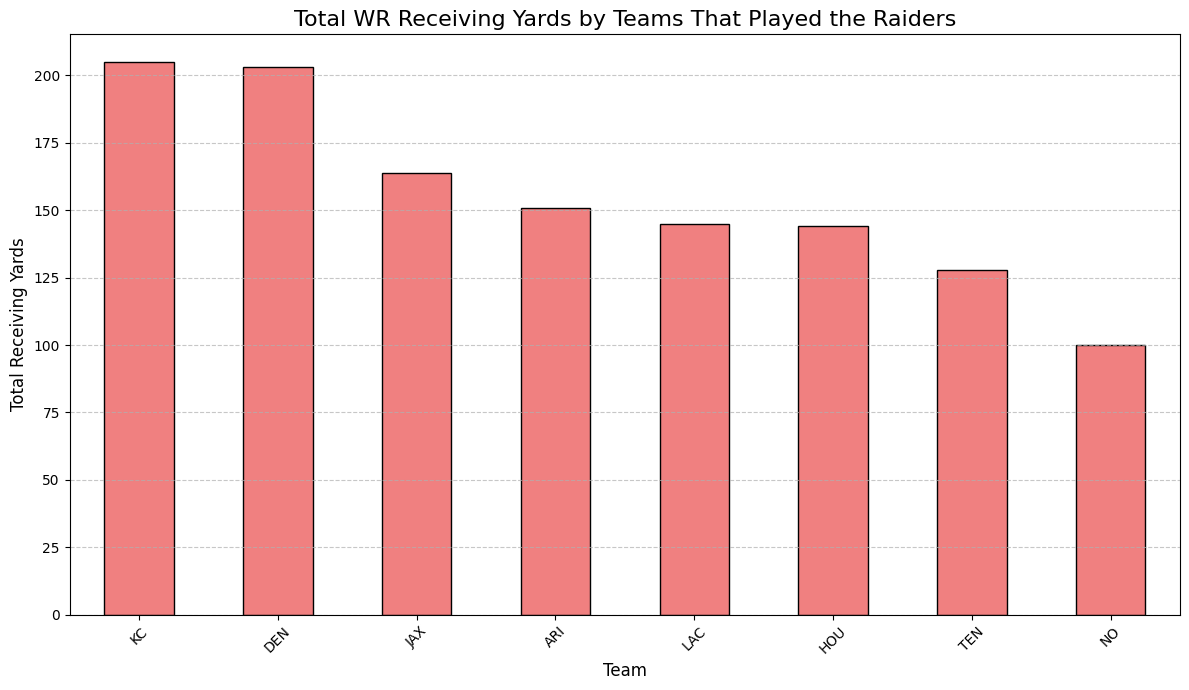

In [54]:
import matplotlib.pyplot as plt

# Ensure 'receivingYards' exists and filter the data for teams that played the Raiders
if 'receivingYards' in opposing_team_wrs.columns:
    # Group by team and sum up receiving yards
    receiving_yards_by_team = opposing_team_wrs.groupby('teamAbbr')['receivingYards'].sum().sort_values(ascending=False)

    # Create a bar chart
    plt.figure(figsize=(12, 7))
    receiving_yards_by_team.plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title('Total WR Receiving Yards by Teams That Played the Raiders', fontsize=16)
    plt.xlabel('Team', fontsize=12)
    plt.ylabel('Total Receiving Yards', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("The column 'receivingYards' does not exist in the dataset.")


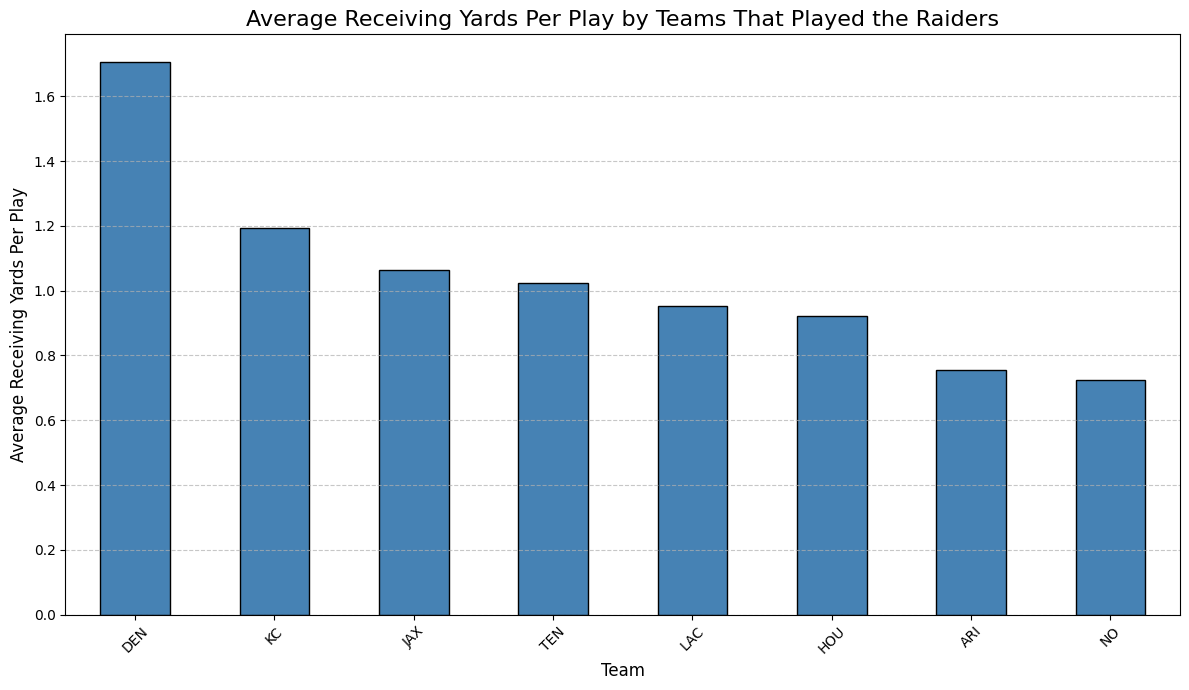

In [55]:
import matplotlib.pyplot as plt

# Calculate average receiving yards per play by team
avg_receiving_yards_per_play = (
    opposing_team_wrs.groupby('teamAbbr')['receivingYards'].mean().sort_values(ascending=False)
)

# Create a bar chart
plt.figure(figsize=(12, 7))
avg_receiving_yards_per_play.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Average Receiving Yards Per Play by Teams That Played the Raiders', fontsize=16)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Average Receiving Yards Per Play', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


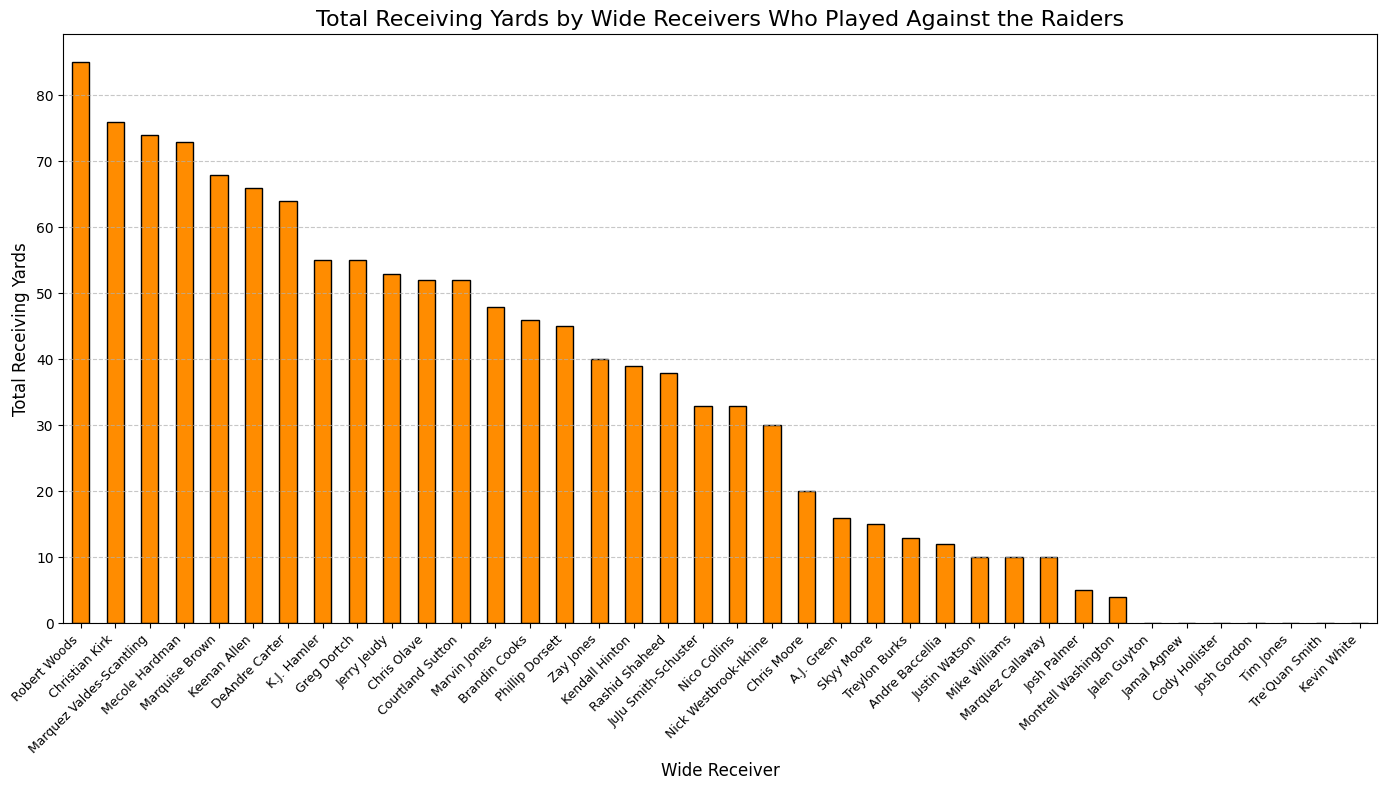

In [57]:
import matplotlib.pyplot as plt

# Calculate total receiving yards for each WR who played against the Raiders
receiving_yards_by_wr = opposing_team_wrs.groupby('displayName')['receivingYards'].sum().sort_values(ascending=False)

# Create a bar chart for receiving yards by WR
plt.figure(figsize=(14, 8))
receiving_yards_by_wr.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title('Total Receiving Yards by Wide Receivers Who Played Against the Raiders', fontsize=16)
plt.xlabel('Wide Receiver', fontsize=12)
plt.ylabel('Total Receiving Yards', fontsize=12)
plt.xticks(rotation=45, fontsize=9, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [59]:
# Function to calculate and print the proportion of missing values for a dataset
def print_missing_proportions(dataset, dataset_name):
    print(f"Missing Value Proportions for {dataset_name}:\n")
    missing_proportions = dataset.isnull().mean() * 100
    # Filter and sort missing proportions
    missing_columns = missing_proportions[missing_proportions > 0].sort_values(ascending=False)
    if not missing_columns.empty:
        print(missing_columns)
    else:
        print("No missing values found.")
    print("\n" + "-"*50 + "\n")

# Calculate and print missing proportions for each dataset
print_missing_proportions(tracking_data, 'Plays Dataset')
print_missing_proportions(opposing_team_wrs, 'opposing_team_wrs Dataset')


Missing Value Proportions for Plays Dataset:

event           98.032918
nflId            4.347826
jerseyNumber     4.347826
o                4.347749
dir              4.347749
dtype: float64

--------------------------------------------------

Missing Value Proportions for opposing_team_wrs Dataset:

pff_secondaryDefensiveCoverageMatchupNflId    100.000000
blockedPlayerNFLId2                           100.000000
timeToPressureAsPassRusher                    100.000000
getOffTimeAsPassRusher                        100.000000
pff_primaryDefensiveCoverageMatchupNflId      100.000000
pff_defensiveCoverageAssignment               100.000000
timeToPressureAllowedAsBlocker                100.000000
blockedPlayerNFLId3                           100.000000
wasInitialPassRusher                          100.000000
penaltyNames                                   99.917763
blockedPlayerNFLId1                            99.835526
pressureAllowedAsBlocker                       99.753289
motionSinceLin

In [61]:
# Function to drop columns with more than 50% missing values
def drop_high_missing_columns(dataset, dataset_name, threshold=60):
    missing_proportions = dataset.isnull().mean() * 100
    cols_to_drop = missing_proportions[missing_proportions > threshold].index
    print(f"Dropping columns from {dataset_name}: {list(cols_to_drop)}")
    return dataset.drop(columns=cols_to_drop)

# Drop columns with more than 50% missing values in each dataset
tracking_data_cleaned = drop_high_missing_columns(tracking_data, 'Plays Dataset')
opposing_team_wrs_cleaned = drop_high_missing_columns(opposing_team_wrs, 'Player_Play Dataset')


# Confirm remaining columns
print(f"Remaining columns in Tracking Dataset: {list(tracking_data_cleaned.columns)}")
print(f"Remaining columns in Player_Play Dataset: {list(opposing_team_wrs_cleaned.columns)}")



Dropping columns from Plays Dataset: ['event']
Dropping columns from Player_Play Dataset: ['penaltyNames', 'wasInitialPassRusher', 'timeToPressureAsPassRusher', 'getOffTimeAsPassRusher', 'blockedPlayerNFLId1', 'blockedPlayerNFLId2', 'blockedPlayerNFLId3', 'pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'pff_defensiveCoverageAssignment', 'pff_primaryDefensiveCoverageMatchupNflId', 'pff_secondaryDefensiveCoverageMatchupNflId']
Remaining columns in Tracking Dataset: ['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'frameType', 'time', 'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']
Remaining columns in Player_Play Dataset: ['gameId', 'playId', 'nflId', 'teamAbbr', 'hadRushAttempt', 'rushingYards', 'hadDropback', 'passingYards', 'sackYardsAsOffense', 'hadPassReception', 'receivingYards', 'wasTargettedReceiver', 'yardageGainedAfterTheCatch', 'fumbles', 'fumbleLost', 'fumbleOutOfBounds', 'assistedTackle', 'forcedFumbleAsDefense', 'halfSack

In [64]:

print(tracking_data_cleaned.shape)
print(opposing_team_wrs_cleaned.shape)


(2592215, 17)
(1216, 40)


In [82]:
no_reception = ((opposing_team_wrs_cleaned['receivingYards'] == 0) & 
                (opposing_team_wrs_cleaned['hadPassReception'] == 0)).sum()
had_reception = (opposing_team_wrs_cleaned['hadPassReception'] == 1).sum()

# Count receivingYards occurrences
zero_count = (opposing_team_wrs_cleaned['receivingYards'] == 0 ).sum()
above_zero_count = (opposing_team_wrs_cleaned['receivingYards'] > 0).sum()
below_zero_count = (opposing_team_wrs_cleaned['receivingYards'] < 0).sum()

# Print results
print(f"no_reception: {no_reception}")
print(f"had_reception: {had_reception}")

print(f"Occurrences of receivingYards == 0: {zero_count}")
print(f"Occurrences of receivingYards > 0: {above_zero_count}")
print(f"Occurrences of receivingYards < 0: {below_zero_count}")




no_reception: 1116
had_reception: 100
Occurrences of receivingYards == 0: 1118
Occurrences of receivingYards > 0: 97
Occurrences of receivingYards < 0: 1


In [95]:
# Step 1: Aggregate frame-level data from tracking_data_cleaned
aggregated_tracking = (
    tracking_data_cleaned
    .groupby(['gameId', 'playId', 'nflId'])
    .agg({
        'frameId': 'count',  # Number of frames
        'x': ['mean', 'max', 'min'],  # Positional data
        'y': ['mean', 'max', 'min'],
        's': ['mean', 'max'],  # Speed
        'a': ['mean', 'max'],  # Acceleration
        'dis': ['mean', 'max'],  # Distance
    })
)

# Flatten the column MultiIndex from aggregation
aggregated_tracking.columns = ['_'.join(col).strip() for col in aggregated_tracking.columns.values]
aggregated_tracking.reset_index(inplace=True)

# Step 2: Merge aggregated tracking data with wide receiver data
merged_data = opposing_team_wrs_cleaned.merge(
    aggregated_tracking,
    on=['gameId', 'playId', 'nflId'],  # Merge on common keys
    how='inner'
)

# Step 3: Inspect the merged dataset
print(f"Merged data shape: {merged_data.shape}")
print(merged_data.head())
merged_data.drop(columns = ["hadDropback","hadPassReception","rushingYards", "hadRushAttempt", "rushingYards",
        "wasTargettedReceiver", "yardageGainedAfterTheCatch", "fumbles", "fumbleLost",
       "fumbleOutOfBounds", "assistedTackle", "forcedFumbleAsDefense",
       "halfSackYardsAsDefense", "passDefensed", "quarterbackHit",
       "sackYardsAsDefense", "safetyAsDefense", "soloTackle", "tackleAssist",
       "tackleForALoss", "tackleForALossYardage", "hadInterception",
       "interceptionYards", "fumbleRecoveries", "fumbleRecoveryYards",
       "penaltyYards", "causedPressure"],inplace = True)
print(merged_data.columns)

Merged data shape: (1216, 53)
       gameId  playId  nflId teamAbbr  hadRushAttempt  rushingYards  \
0  2022091111      55  40024      LAC               0             0   
1  2022091111      55  44819      LAC               0             0   
2  2022091111      55  53506      LAC               0             0   
3  2022091111      76  40024      LAC               0             0   
4  2022091111      76  44819      LAC               0             0   

   hadDropback  passingYards  sackYardsAsOffense  hadPassReception  ...  \
0            0             0                   0                 0  ...   
1            0             0                   0                 0  ...   
2            0             0                   0                 0  ...   
3            0             0                   0                 1  ...   
4            0             0                   0                 0  ...   

   x_min     y_mean  y_max  y_min    s_mean  s_max    a_mean  a_max  dis_mean  \
0  31.73  2

In [97]:
# Split X (features) and y (target)
X = merged_data.drop(columns=['receivingYards'])
y = merged_data['receivingYards']

# Handle missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.feature_selection import RFE

# Separate numerical and categorical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Apply preprocessor
X_transformed = preprocessor.fit_transform(X)
processed_columns = (
    numerical_columns.tolist() +
    preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns).tolist()
)
X_processed = pd.DataFrame(X_transformed, columns=processed_columns)

# Feature selection with RFE
def rfe_feature_selection(X, y, n_features_to_select=1):
    model = xgb.XGBRegressor()
    rfe_selector = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
    rfe_selector = rfe_selector.fit(X, y)
    return rfe_selector

n_features_to_select = 5
rfe_selector = rfe_feature_selection(X_processed, y)
important_features = [
    processed_columns[i] for i in range(len(processed_columns)) if rfe_selector.support_[i]
]
print("Most Important Features:", important_features)


Most Important Features: ['displayName_K.J. Hamler']


In [100]:
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb

# Perform RFE with XGBRegressor
max_features = len(X_processed.columns)
best_score = float('-inf')  # Initialize to negative infinity for regression
best_n_features = 0

for n in range(1, max_features + 1):
    rfe_selector = rfe_feature_selection(X_processed, y, n_features_to_select=n)
    selected_features = X_processed.columns[rfe_selector.support_].tolist()
    X_subset = X_processed[selected_features]
    
    # Use XGBRegressor for regression
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Use negative RMSE for scoring
    scores = cross_val_score(model, X_subset, y, cv=cv, scoring='neg_root_mean_squared_error')
    mean_score = -scores.mean()  # Negate to get RMSE (lower is better)
    
    # Update best score and number of features if current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_n_features = n

print(f"Optimal number of features: {best_n_features}")
print(f"Best RMSE score: {best_score:.4f}")


Optimal number of features: 12
Best RMSE score: 5.8542


In [102]:
# Select the best features
rfe_selector = rfe_feature_selection(X_processed, y, best_n_features)
selected_features = X_processed.columns[rfe_selector.support_].tolist()
X_selected = X_processed[selected_features]

X_selected.head()

,x_mean,a_max,routeRan_CROSS,routeRan_GO,displayName_Christian Kirk,displayName_DeAndre Carter,displayName_Jerry Jeudy,displayName_K.J. Hamler,displayName_Keenan Allen,displayName_Marquez Valdes-Scantling,displayName_Mecole Hardman,displayName_Robert Woods
0,-0.986034,-0.782945,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.041481,-0.451700,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.019841,-0.416461,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.710238,-0.930948,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.657920,-0.839327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
import optuna
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import xgboost as xgb
import numpy as np

# Define objective function for Optuna
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    model = xgb.XGBRegressor(**param, objective='reg:squarederror', random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Use negative RMSE for scoring
    scores = cross_val_score(model, X_selected, y, cv=cv, scoring='neg_root_mean_squared_error')
    return -scores.mean()  # Convert to positive RMSE

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train final model with best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
final_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = final_model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('RMSE:', rmse)
print('R^2 Score:', r2)


[I 2024-11-19 03:54:50,674] A new study created in memory with name: no-name-37079300-661e-4ba0-88d1-fb45f98dc1e8
[I 2024-11-19 03:54:52,466] Trial 0 finished with value: 5.04046640846034 and parameters: {'max_depth': 5, 'n_estimators': 816, 'learning_rate': 0.06946108117431975, 'subsample': 0.6983223766704127, 'colsample_bytree': 0.8109185706816631, 'gamma': 4.403895141393608, 'min_child_weight': 4}. Best is trial 0 with value: 5.04046640846034.
[I 2024-11-19 03:54:53,682] Trial 1 finished with value: 5.190206114997891 and parameters: {'max_depth': 3, 'n_estimators': 773, 'learning_rate': 0.24255789743977796, 'subsample': 0.8895048684184232, 'colsample_bytree': 0.8198005053054654, 'gamma': 3.4306531703757615, 'min_child_weight': 7}. Best is trial 0 with value: 5.04046640846034.
[I 2024-11-19 03:54:55,971] Trial 2 finished with value: 5.07973118728809 and parameters: {'max_depth': 9, 'n_estimators': 787, 'learning_rate': 0.07056079964817559, 'subsample': 0.5394634251516588, 'colsample_

Best hyperparameters: {'max_depth': 5, 'n_estimators': 960, 'learning_rate': 0.02035883050313829, 'subsample': 0.9685341116440118, 'colsample_bytree': 0.9633822134444212, 'gamma': 4.432206342987318, 'min_child_weight': 2}
RMSE: 4.243675819493735
R^2 Score: -0.18950890843070423


<Figure size 1200x800 with 0 Axes>

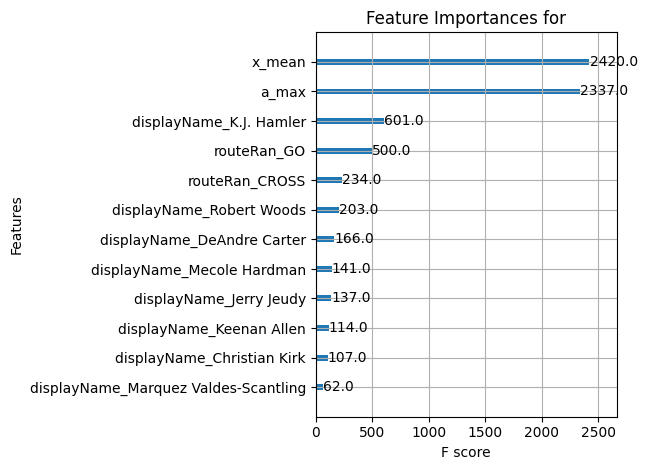

In [108]:
# Plot Feature Importances
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=20)
plt.title('Feature Importances for Predicting Recieving Yards')
plt.tight_layout()
plt.show()

In [106]:
# Calculate baseline RMSE
baseline_prediction = y_train.mean()  # Predict the mean of the training target
baseline_rmse = np.sqrt(mean_squared_error(y_test, [baseline_prediction] * len(y_test)))
print('Baseline RMSE:', baseline_rmse)


Baseline RMSE: 3.8971618973466917


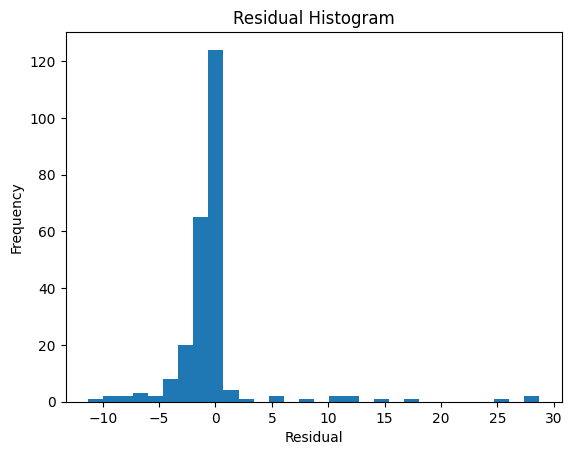

In [107]:
residuals = y_test - y_pred
plt.hist(residuals, bins=30)
plt.title('Residual Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()
